# Model Pembanding Collaborative fIltering - Alternating Least Square


### Import Libraries and Load Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, mean, stddev, count, avg
from google.colab import drive
from scipy.sparse import csr_matrix

* **pandas, numpy**: Digunakan untuk manipulasi data dan operasi numerik.
* **sklearn.preprocessing.LabelEncoder**: Untuk melakukan encoding pada variabel kategorikal.
* **matplotlib.pyplot**: Untuk visualisasi hasil evaluasi model.
* **pyspark.sql**: Menggunakan PySpark untuk memproses data besar secara terdistribusi.
* **scipy.sparse.csr_matrix**: Digunakan untuk menyimpan matriks dalam format yang efisien.

In [ ]:
drive.mount('/content/gdrive')

# Membaca Data CSV ke dalam DataFrame Pandas
file_path = '/content/gdrive/MyDrive/Dataset/Tempat-Wisata-Toba-Preprocessing.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Menangani Missing Values dalam Data
def handle_missing_data(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    if missing.empty:
        print("Tidak ada nilai yang hilang.")
    else:
        print(f"Nilai yang hilang di setiap kolom:\n{missing}")

handle_missing_data(df)

# Menghapus Kolom yang Tidak Diperlukan
df = df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])

# Mengisi Missing Values pada Kolom 'Reviews' dengan String Kosong
df['Reviews'] = df['Reviews'].fillna('')

# Melakukan Encoding pada Kolom Kategorikal
place_encoder = LabelEncoder()
df['PlaceID'] = place_encoder.fit_transform(df['Nama_tempat_wisata'])

category_encoder = LabelEncoder()
df['Category'] = category_encoder.fit_transform(df['Category'])

reviewer_encoder = LabelEncoder()
df['ReviewerId'] = reviewer_encoder.fit_transform(df['ReviewerId'])

# Memeriksa Data yang Telah Diproses
df.head()

Nilai yang hilang di setiap kolom:
Reviews               21060
ReviewerId                1
Rating                    1
Unnamed: 0.1              0
Unnamed: 0                0
address                   0
PlaceID                   0
Nama_tempat_wisata        0
Category                  0
dtype: int64


,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews
0,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,1,10261,5.0,
1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,1,9698,5.0,bagus
2,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,1,6433,5.0,
3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,1,10643,5.0,sangat menyenagkan
4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",51,PASIR PUTIH LUMBAN BULBUL,1,5078,5.0,bebas foto dimana aja cuma 2k




*   Fungsi handle_missing_data digunakan untuk mengecek apakah ada nilai yang hilang pada dataset.
*   Menghapus kolom yang tidak diperlukan.
* Mengisi nilai kosong pada kolom "Reviews" dengan string kosong agar tidak ada nilai yang hilang.
* Melakukan encoding pada kolom yang mengandung data kategorikal seperti Nama_tempat_wisata, Category, dan ReviewerId menjadi format numerik agar dapat digunakan oleh model ALS.




### Create Spark Session

In [ ]:
# Membuat SparkSession
spark = SparkSession.builder.appName("ALS_Recommendation").getOrCreate()

# Mengonversi DataFrame Pandas ke Spark DataFrame
spark_df = spark.createDataFrame(df)

# Menangani Missing Data dengan Menghapus Baris yang Mengandung Nilai NaN
spark_df = spark_df.dropna(subset=["ReviewerId", "PlaceID", "Rating"])

# Melakukan Normalisasi pada Kolom 'Rating'
rating_stats = spark_df.select(mean("Rating").alias("mean"), stddev("Rating").alias("std")).first()
mean_rating, std_rating = rating_stats["mean"], rating_stats["std"]

spark_df = spark_df.withColumn("NormalizedRating", (col("Rating") - mean_rating) / std_rating)

* SparkSession dibuat untuk memungkinkan interaksi dengan PySpark.
* Data yang sudah diproses diubah menjadi Spark DataFrame.
* Menghapus baris dengan nilai kosong di kolom yang relevan untuk model (seperti ReviewerId, PlaceID, dan Rating).
* Normalisasi dilakukan pada kolom Rating untuk mengurangi bias skala rating yang berbeda-beda antar pengguna atau tempat wisata.

### Data Splitting

In [ ]:
# Membagi Data Menjadi Training, Validation, dan Test Set
train_data, val_data, test_data = spark_df.randomSplit([0.75, 0.15, 0.15], seed=42)

# Mencetak Jumlah Data Setiap Split
print(f"Training Set: {train_data.count()} rows")
print(f"Validation Set: {val_data.count()} rows")
print(f"Test Set: {test_data.count()} rows")

Training Set: 31058 rows
Validation Set: 6065 rows
Test Set: 6102 rows


Data dibagi menjadi tiga bagian: data latih (75%), validasi (15%), dan data uji (15%).

### Build ALS Model and Train Data

In [ ]:
# Membangun Model ALS
als_model = ALS(
    userCol="ReviewerId",
    itemCol="PlaceID",
    ratingCol="NormalizedRating",
    rank=10,
    maxIter=15,
    regParam=0.2,
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop"
)

# Melatih Model dengan Data Latih
als_trained_model = als_model.fit(train_data)

Membuat model ALS untuk rekomendasi. Model ini mempelajari preferensi pengguna berdasarkan interaksi dengan item (tempat wisata) menggunakan algoritma Alternating Least Squares.

### Evaluate the Model (RMSE and MAE on Validation)

In [ ]:
# Evaluasi Model pada Validation Set dengan RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="NormalizedRating", predictionCol="prediction")
validation_predictions = als_trained_model.transform(val_data).dropna(subset=["prediction"])
val_rmse = evaluator.evaluate(validation_predictions)
print(f"Validation RMSE: {val_rmse}")

# Evaluasi dengan MAE
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="NormalizedRating", predictionCol="prediction")
val_mae = mae_evaluator.evaluate(validation_predictions)
print(f"Validation MAE: {val_mae}")

Validation RMSE: 0.997558396951096
Validation MAE: 0.7030104679389011


Model dievaluasi menggunakan Root Mean Squared Error (RMSE) dan Mean Absolute Error (MAE) untuk mengukur kinerja model dalam memprediksi rating.

### Evaluate the Model (RMSE and MAE on Test Set)

In [ ]:
# Evaluasi Model pada Test Set
test_predictions = als_trained_model.transform(test_data).dropna(subset=["prediction"])
test_rmse = evaluator.evaluate(test_predictions)
test_mae = mae_evaluator.evaluate(test_predictions)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")

Test RMSE: 0.960887673886217
Test MAE: 0.6853495079378059


### Visualisasi RMSE and MAE

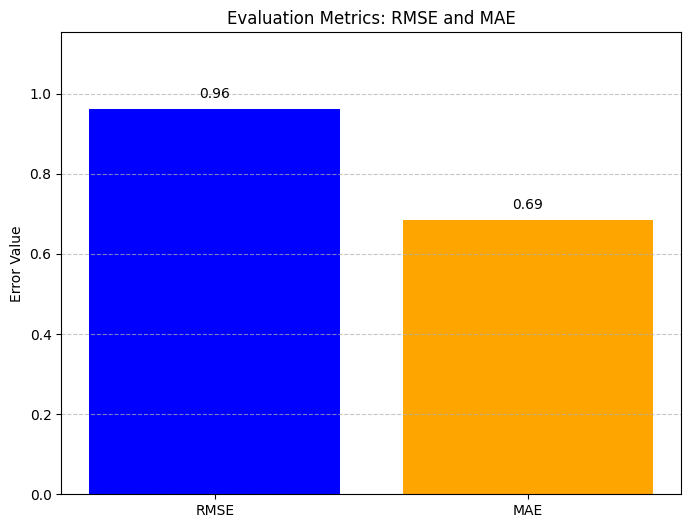

+-------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+
|PlaceID|ReviewerId|recommendations                                                                                                                                                                 |Nama_tempat_wisata                  |
+-------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+
|22     |1         |[{31, 0.28178}, {22, 0.27387094}, {44, 0.2462116}, {24, 0.24440843}, {15, 0.24251826}, {97, 0.2384093}, {37, 0.23214492}, {32, 0.23195261}, {18, 0.22586334}, {60, 0.22394812}] |Bukit Indah Simarjarunjung          |
|32     |1         |[{31, 0.28178}, {22, 0.27387094}, {44, 0

In [ ]:
# Visualisasi Hasil Evaluasi
metrics = pd.DataFrame({
    "Metric": ["RMSE", "MAE"],
    "Value": [test_rmse, test_mae]
})

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics["Metric"], metrics["Value"], color=['blue', 'orange'])
plt.title("Evaluation Metrics: RMSE and MAE")
plt.ylabel("Error Value")
plt.ylim(0, max(metrics["Value"]) * 1.2)

# Menambahkan Nilai di Atas Setiap Bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, round(yval, 2), ha='center', va='bottom')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Menampilkan Rekomendasi untuk Setiap Pengguna
K = 10
user_recs = als_trained_model.recommendForAllUsers(K)

# Mengambil Nama Tempat dari Data
place_name_df = spark_df.select("PlaceID", "Nama_tempat_wisata").distinct()

# Menggabungkan Rekomendasi dengan Nama Tempat
user_recs_with_names = user_recs.withColumn("PlaceID", explode(col("recommendations.PlaceID"))) \
    .join(place_name_df, on="PlaceID", how="left")

# Menampilkan Hasil Rekomendasi dengan Nama Tempat
user_recs_with_names.show(10, truncate=False)

# Menghitung Precision, Recall, dan MAP untuk Evaluasi Rekomendasi
from pyspark.sql.functions import collect_list

# Menyusun Ground Truth
actual_places = spark_df.groupBy("ReviewerId").agg(collect_list("PlaceID").alias("ActualPlaces"))

# Menggabungkan Rekomendasi dengan Ground Truth
recommendation_df = user_recs_with_names.withColumn("RecommendedPlaces", col("recommendations.PlaceID")) \
    .join(actual_places, on="ReviewerId")



### Evaluate MAP, Recall, Precision

In [ ]:
# Fungsi Evaluasi Precision, Recall, dan MAP
def precision_at_k(actual, predicted, k):
    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    return len(actual_set & predicted_set) / k

def recall_at_k(actual, predicted, k):
    actual_set = set(actual)
    predicted_set = set(predicted[:k])
    return len(actual_set & predicted_set) / len(actual_set) if len(actual_set) > 0 else 0

def map_at_k(actual, predicted, k):
    score, hits = 0.0, 0
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            hits += 1
            score += hits / (i + 1.0)
    return score / min(len(actual), k) if actual else 0.0

# Menghitung Precision, Recall, dan MAP untuk Setiap Pengguna
evaluation_results = recommendation_df.rdd.map(lambda row: (
    row["ReviewerId"],
    precision_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K),
    recall_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K),
    map_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K)
))

# Mengubah Hasil ke dalam DataFrame
evaluation_results_df = evaluation_results.toDF(["ReviewerId", "Precision", "Recall", "MAP"])

# Menghitung Rata-rata Metrics
avg_precision = evaluation_results_df.select("Precision").rdd.map(lambda x: x[0]).mean()
avg_recall = evaluation_results_df.select("Recall").rdd.map(lambda x: x[0]).mean()
avg_map = evaluation_results_df.select("MAP").rdd.map(lambda x: x[0]).mean()

print(f"Average Precision at {K}: {avg_precision}")
print(f"Average Recall at {K}: {avg_recall}")
print(f"Mean Average Precision at {K}: {avg_map}")


Average Precision at 10: 0.05232688429072933
Average Recall at 10: 0.260346090917755
Mean Average Precision at 10: 0.0800676454095777


### Visualisasi MAP, Recall, Precision

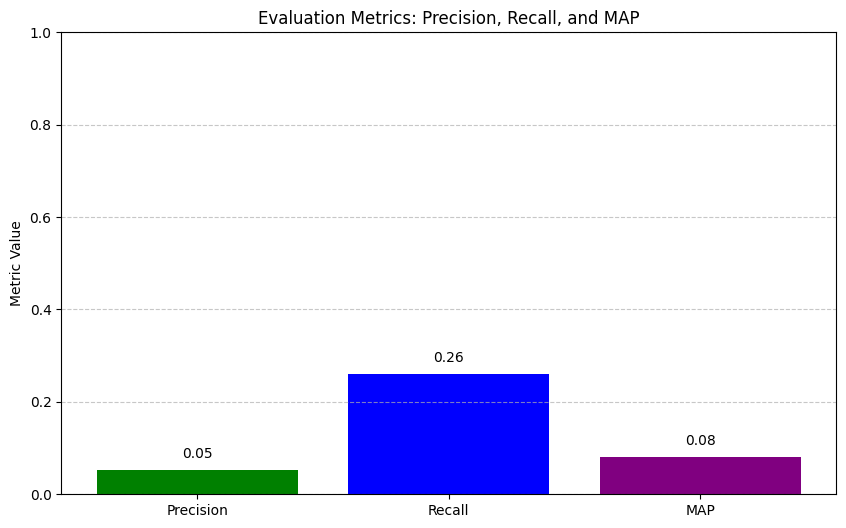

      Metric     Value
0  Precision  0.052327
1     Recall  0.260346
2        MAP  0.080068
+-------+----------+-----------------------------------------------------------------------------------------+------------------------------------+
|PlaceID|ReviewerId|recommendations                                                                          |Nama_tempat_wisata                  |
+-------+----------+-----------------------------------------------------------------------------------------+------------------------------------+
|22     |1         |[{31, 0.28178}, {22, 0.27387094}, {44, 0.2462116}, {24, 0.24440843}, {15, 0.24251826}]   |Bukit Indah Simarjarunjung          |
|31     |1         |[{31, 0.28178}, {22, 0.27387094}, {44, 0.2462116}, {24, 0.24440843}, {15, 0.24251826}]   |Desa Wisata Sigapiton               |
|31     |3         |[{31, 0.3589338}, {69, 0.34727076}, {20, 0.32473913}, {37, 0.31156722}, {29, 0.31111565}]|Desa Wisata Sigapiton               |
|44     |1         |

In [ ]:
# Visualisasi Hasil Evaluasi
metrics_data = pd.DataFrame({
    "Metric": ["Precision", "Recall", "MAP"],
    "Value": [avg_precision, avg_recall, avg_map]
})

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_data["Metric"], metrics_data["Value"], color=['green', 'blue', 'purple'])
plt.title("Evaluation Metrics: Precision, Recall, and MAP")
plt.ylabel("Metric Value")
plt.ylim(0, 1)

# Menambahkan Nilai di Atas Setiap Bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


("Evaluation Metrics (Precision, Recall, MAP):")
print(metrics_data)

# Menampilkan Top 5 Rekomendasi untuk Setiap Pengguna
K = 5  # Ubah ke 5 untuk menampilkan top 5 rekomendasi
user_recs_top_5 = als_trained_model.recommendForAllUsers(K)

# Mengambil Nama Tempat dari Data
place_name_df = spark_df.select("PlaceID", "Nama_tempat_wisata").distinct()

# Menggabungkan Rekomendasi dengan Nama Tempat
user_recs_with_names = user_recs_top_5.withColumn("PlaceID", explode(col("recommendations.PlaceID"))) \
    .join(place_name_df, on="PlaceID", how="left")

# Menampilkan Hasil Rekomendasi dengan Nama Tempat
user_recs_with_names.show(5, truncate=False)

Precision, Recall, dan Mean Average Precision (MAP) dihitung untuk setiap pengguna untuk mengevaluasi seberapa baik rekomendasi yang diberikan oleh model.

Grafik yang diberikan menunjukkan evaluasi dari model rekomendasi berdasarkan dua kelompok metrik:

### **Grafik 1: RMSE dan MAE**
- **RMSE (Root Mean Square Error):** Nilainya adalah **0.96**, ditampilkan dengan batang biru. Nilai ini mengukur seberapa besar perbedaan antara prediksi model dan nilai aktual, di mana nilai yang lebih rendah menunjukkan performa prediksi yang lebih baik.
- **MAE (Mean Absolute Error):** Nilainya adalah **0.69**, ditampilkan dengan batang oranye. MAE mengukur rata-rata kesalahan absolut tanpa mempertimbangkan arah kesalahan, dan seperti RMSE, nilai yang lebih kecil menunjukkan performa yang lebih baik.

> **Kesimpulan:** Model menunjukkan kesalahan prediksi yang moderat berdasarkan nilai RMSE dan MAE. RMSE yang lebih tinggi dari MAE menunjukkan bahwa ada beberapa kesalahan besar yang memengaruhi hasil RMSE secara signifikan.

---

### **Grafik 2: Precision, Recall, dan MAP**
- **Precision:** Nilainya adalah **0.05**, ditampilkan dengan batang hijau. Ini menunjukkan persentase item yang direkomendasikan yang benar-benar relevan. Nilai precision yang rendah menunjukkan bahwa model cenderung merekomendasikan banyak item yang tidak relevan.
- **Recall:** Nilainya adalah **0.26**, ditampilkan dengan batang biru. Recall menunjukkan sejauh mana model dapat merekomendasikan semua item relevan. Nilai recall ini moderat, menunjukkan model menangkap sebagian kecil dari item relevan.
- **MAP (Mean Average Precision):** Nilainya adalah **0.08**, ditampilkan dengan batang ungu. MAP mengukur akurasi keseluruhan model pada berbagai level peringkat rekomendasi. Nilai rendah menunjukkan bahwa model memiliki kesulitan menghasilkan rekomendasi yang konsisten relevan di peringkat atas.

> **Kesimpulan:** Model memiliki performa yang kurang baik dalam merekomendasikan item relevan, terlihat dari precision dan MAP yang rendah. Namun, recall yang lebih tinggi menunjukkan bahwa model berhasil menangkap beberapa item relevan meskipun dengan tingkat akurasi rendah.

---

### **Analisis Keseluruhan:**
Model ini menunjukkan performa yang moderat untuk kesalahan prediksi (RMSE dan MAE), tetapi memiliki tantangan dalam metrik relevansi seperti precision dan MAP. Ini menunjukkan model mungkin lebih cocok untuk menangkap pola umum daripada memberikan rekomendasi yang sangat akurat atau relevan. Perbaikan dapat difokuskan pada meningkatkan precision dan MAP, misalnya dengan algoritma rekomendasi yang lebih personalisasi atau mempertimbangkan relevansi yang lebih tinggi.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Nilai yang hilang di setiap kolom:
Reviews               21060
ReviewerId                1
Rating                    1
Unnamed: 0.1              0
Unnamed: 0                0
address                   0
PlaceID                   0
Nama_tempat_wisata        0
Category                  0
dtype: int64
Training Set: 31058 rows
Validation Set: 6065 rows
Test Set: 6102 rows
Validation RMSE: 0.997558396951096
Validation MAE: 0.7030104679389011
Test RMSE: 0.960887673886217
Test MAE: 0.6853495079378059


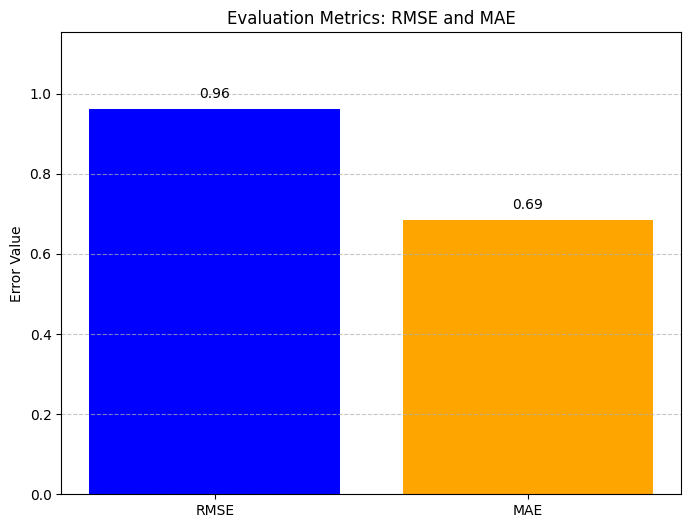

+-------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+
|PlaceID|ReviewerId|recommendations                                                                                                                                                                 |Nama_tempat_wisata                  |
+-------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------+
|22     |1         |[{31, 0.28178}, {22, 0.27387094}, {44, 0.2462116}, {24, 0.24440843}, {15, 0.24251826}, {97, 0.2384093}, {37, 0.23214492}, {32, 0.23195261}, {18, 0.22586334}, {60, 0.22394812}] |Bukit Indah Simarjarunjung          |
|32     |1         |[{31, 0.28178}, {22, 0.27387094}, {44, 0

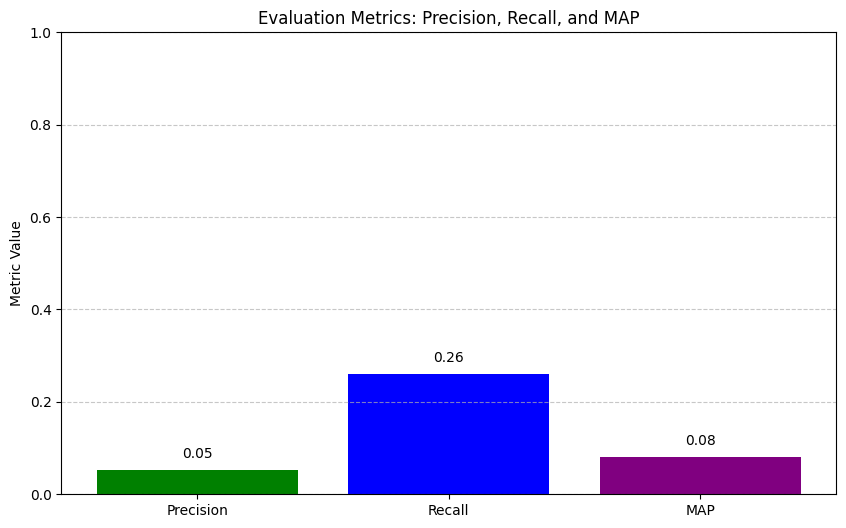

      Metric     Value
0  Precision  0.052327
1     Recall  0.260346
2        MAP  0.080068
+-------+----------+-----------------------------------------------------------------------------------------+------------------------------------+
|PlaceID|ReviewerId|recommendations                                                                          |Nama_tempat_wisata                  |
+-------+----------+-----------------------------------------------------------------------------------------+------------------------------------+
|22     |1         |[{31, 0.28178}, {22, 0.27387094}, {44, 0.2462116}, {24, 0.24440843}, {15, 0.24251826}]   |Bukit Indah Simarjarunjung          |
|31     |1         |[{31, 0.28178}, {22, 0.27387094}, {44, 0.2462116}, {24, 0.24440843}, {15, 0.24251826}]   |Desa Wisata Sigapiton               |
|31     |3         |[{31, 0.3589338}, {69, 0.34727076}, {20, 0.32473913}, {37, 0.31156722}, {29, 0.31111565}]|Desa Wisata Sigapiton               |
|44     |1         |

In [ ]:

# ### Kode yang Dimodifikasi:

# # Import Library yang Diperlukan
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# import matplotlib.pyplot as plt
# from pyspark.sql import SparkSession
# from pyspark.ml.recommendation import ALS
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.sql.functions import col, mean, stddev, count, avg
# from google.colab import drive
# from scipy.sparse import csr_matrix


# # Mount Google Drive untuk Akses Data
# drive.mount('/content/gdrive')

# # Membaca Data CSV ke dalam DataFrame Pandas
# file_path = '/content/gdrive/MyDrive/Dataset/Tempat-Wisata-Toba-Preprocessing.csv'
# df = pd.read_csv(file_path)

# # Menangani Missing Values dalam Data
# def handle_missing_data(df):
#     missing = df.isnull().sum().sort_values(ascending=False)
#     if missing.empty:
#         print("Tidak ada nilai yang hilang.")
#     else:
#         print(f"Nilai yang hilang di setiap kolom:\n{missing}")

# handle_missing_data(df)

# # Menghapus Kolom yang Tidak Diperlukan
# df = df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"])

# # Mengisi Missing Values pada Kolom 'Reviews' dengan String Kosong
# df['Reviews'] = df['Reviews'].fillna('')

# # Melakukan Encoding pada Kolom Kategorikal
# place_encoder = LabelEncoder()
# df['PlaceID'] = place_encoder.fit_transform(df['Nama_tempat_wisata'])

# category_encoder = LabelEncoder()
# df['Category'] = category_encoder.fit_transform(df['Category'])

# reviewer_encoder = LabelEncoder()
# df['ReviewerId'] = reviewer_encoder.fit_transform(df['ReviewerId'])

# # Memeriksa Data yang Telah Diproses
# df.head()

# # Membuat SparkSession
# spark = SparkSession.builder.appName("ALS_Recommendation").getOrCreate()

# # Mengonversi DataFrame Pandas ke Spark DataFrame
# spark_df = spark.createDataFrame(df)

# # Menangani Missing Data dengan Menghapus Baris yang Mengandung Nilai NaN
# spark_df = spark_df.dropna(subset=["ReviewerId", "PlaceID", "Rating"])

# # Melakukan Normalisasi pada Kolom 'Rating'
# rating_stats = spark_df.select(mean("Rating").alias("mean"), stddev("Rating").alias("std")).first()
# mean_rating, std_rating = rating_stats["mean"], rating_stats["std"]

# spark_df = spark_df.withColumn("NormalizedRating", (col("Rating") - mean_rating) / std_rating)

# # Membagi Data Menjadi Training, Validation, dan Test Set
# train_data, val_data, test_data = spark_df.randomSplit([0.75, 0.15, 0.15], seed=42)

# # Mencetak Jumlah Data Setiap Split
# print(f"Training Set: {train_data.count()} rows")
# print(f"Validation Set: {val_data.count()} rows")
# print(f"Test Set: {test_data.count()} rows")

# # Membangun Model ALS
# als_model = ALS(
#     userCol="ReviewerId",
#     itemCol="PlaceID",
#     ratingCol="NormalizedRating",
#     rank=10,
#     maxIter=15,
#     regParam=0.2,
#     nonnegative=True,
#     implicitPrefs=False,
#     coldStartStrategy="drop"
# )

# # Melatih Model dengan Data Latih
# als_trained_model = als_model.fit(train_data)

# # Evaluasi Model pada Validation Set dengan RMSE
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="NormalizedRating", predictionCol="prediction")
# validation_predictions = als_trained_model.transform(val_data).dropna(subset=["prediction"])
# val_rmse = evaluator.evaluate(validation_predictions)
# print(f"Validation RMSE: {val_rmse}")

# # Evaluasi dengan MAE
# mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="NormalizedRating", predictionCol="prediction")
# val_mae = mae_evaluator.evaluate(validation_predictions)
# print(f"Validation MAE: {val_mae}")

# # Evaluasi Model pada Test Set
# test_predictions = als_trained_model.transform(test_data).dropna(subset=["prediction"])
# test_rmse = evaluator.evaluate(test_predictions)
# test_mae = mae_evaluator.evaluate(test_predictions)

# print(f"Test RMSE: {test_rmse}")
# print(f"Test MAE: {test_mae}")

# # Visualisasi Hasil Evaluasi
# metrics = pd.DataFrame({
#     "Metric": ["RMSE", "MAE"],
#     "Value": [test_rmse, test_mae]
# })

# plt.figure(figsize=(8, 6))
# bars = plt.bar(metrics["Metric"], metrics["Value"], color=['blue', 'orange'])
# plt.title("Evaluation Metrics: RMSE and MAE")
# plt.ylabel("Error Value")
# plt.ylim(0, max(metrics["Value"]) * 1.2)

# # Menambahkan Nilai di Atas Setiap Bar
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, round(yval, 2), ha='center', va='bottom')

# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()

# # Menampilkan Rekomendasi untuk Setiap Pengguna
# K = 10
# user_recs = als_trained_model.recommendForAllUsers(K)

# # Mengambil Nama Tempat dari Data
# place_name_df = spark_df.select("PlaceID", "Nama_tempat_wisata").distinct()

# # Menggabungkan Rekomendasi dengan Nama Tempat
# user_recs_with_names = user_recs.withColumn("PlaceID", explode(col("recommendations.PlaceID"))) \
#     .join(place_name_df, on="PlaceID", how="left")

# # Menampilkan Hasil Rekomendasi dengan Nama Tempat
# user_recs_with_names.show(10, truncate=False)

# # Menghitung Precision, Recall, dan MAP untuk Evaluasi Rekomendasi
# from pyspark.sql.functions import collect_list

# # Menyusun Ground Truth
# actual_places = spark_df.groupBy("ReviewerId").agg(collect_list("PlaceID").alias("ActualPlaces"))

# # Menggabungkan Rekomendasi dengan Ground Truth
# recommendation_df = user_recs_with_names.withColumn("RecommendedPlaces", col("recommendations.PlaceID")) \
#     .join(actual_places, on="ReviewerId")

# # Fungsi Evaluasi Precision, Recall, dan MAP
# def precision_at_k(actual, predicted, k):
#     actual_set = set(actual)
#     predicted_set = set(predicted[:k])
#     return len(actual_set & predicted_set) / k

# def recall_at_k(actual, predicted, k):
#     actual_set = set(actual)
#     predicted_set = set(predicted[:k])
#     return len(actual_set & predicted_set) / len(actual_set) if len(actual_set) > 0 else 0

# def map_at_k(actual, predicted, k):
#     score, hits = 0.0, 0
#     for i, p in enumerate(predicted[:k]):
#         if p in actual:
#             hits += 1
#             score += hits / (i + 1.0)
#     return score / min(len(actual), k) if actual else 0.0

# # Menghitung Precision, Recall, dan MAP untuk Setiap Pengguna
# evaluation_results = recommendation_df.rdd.map(lambda row: (
#     row["ReviewerId"],
#     precision_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K),
#     recall_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K),
#     map_at_k(row["ActualPlaces"], row["RecommendedPlaces"], K)
# ))

# # Mengubah Hasil ke dalam DataFrame
# evaluation_results_df = evaluation_results.toDF(["ReviewerId", "Precision", "Recall", "MAP"])

# # Menghitung Rata-rata Metrics
# avg_precision = evaluation_results_df.select("Precision").rdd.map(lambda x: x[0]).mean()
# avg_recall = evaluation_results_df.select("Recall").rdd.map(lambda x: x[0]).mean()
# avg_map = evaluation_results_df.select("MAP").rdd.map(lambda x: x[0]).mean()

# print(f"Average Precision at {K}: {avg_precision}")
# print(f"Average Recall at {K}: {avg_recall}")
# print(f"Mean Average Precision at {K}: {avg_map}")

# # Visualisasi Hasil Evaluasi
# metrics_data = pd.DataFrame({
#     "Metric": ["Precision", "Recall", "MAP"],
#     "Value": [avg_precision, avg_recall, avg_map]
# })

# plt.figure(figsize=(10, 6))
# bars = plt.bar(metrics_data["Metric"], metrics_data["Value"], color=['green', 'blue', 'purple'])
# plt.title("Evaluation Metrics: Precision, Recall, and MAP")
# plt.ylabel("Metric Value")
# plt.ylim(0, 1)

# # Menambahkan Nilai di Atas Setiap Bar
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()


# ("Evaluation Metrics (Precision, Recall, MAP):")
# print(metrics_data)

# # Menampilkan Top 5 Rekomendasi untuk Setiap Pengguna
# K = 5  # Ubah ke 5 untuk menampilkan top 5 rekomendasi
# user_recs_top_5 = als_trained_model.recommendForAllUsers(K)

# # Mengambil Nama Tempat dari Data
# place_name_df = spark_df.select("PlaceID", "Nama_tempat_wisata").distinct()

# # Menggabungkan Rekomendasi dengan Nama Tempat
# user_recs_with_names = user_recs_top_5.withColumn("PlaceID", explode(col("recommendations.PlaceID"))) \
#     .join(place_name_df, on="PlaceID", how="left")

# # Menampilkan Hasil Rekomendasi dengan Nama Tempat
# user_recs_with_names.show(5, truncate=False)


